In [10]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants, split_participants_into_folds
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights, EarlyStopper
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import read_behavioural_info
from hmpai.visualization import display_trial
from hmpai.behaviour.sat2 import SAT2_SPLITS
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
from copy import deepcopy
import json
from hmpai.pytorch.utilities import save_tensor
import time
from itertools import product
DATA_PATH = Path(os.getenv("DATA_PATH"))
from collections import defaultdict
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Visualization

In [6]:
logs_path = Path("../../logs/model_ablation")

result_files = logs_path.glob("*/*.json")
tmp = []
ablations = ["Linear", "PointConv", "No Spatial"]
for file in result_files:
    parts = file.name.split("_")
    abl = parts[0]
    fold = parts[1].split(".")[0]
    abl_idx = int(abl[8:])
    values = {"ablation": ablations[abl_idx], "fold": fold[4:]}
    with open(file, "r") as file:
        tmp_data = json.load(file)
    values["result"] = tmp_data["test_kldiv_mean"]
    tmp.append(values)
data = pd.DataFrame(tmp)

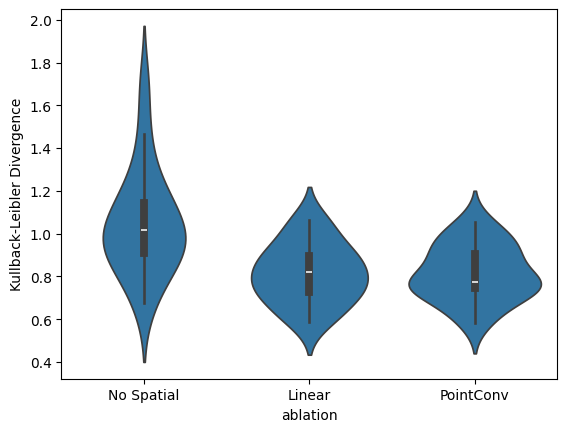

In [12]:
sns.violinplot(data, x="ablation", y="result", order=["No Spatial", "Linear", "PointConv"])
plt.ylabel("Kullback-Leibler Divergence")
plt.show()

#### Run experiment

In [2]:
set_global_seed(42)
N_FOLDS = 19

data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]

# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY
info_to_keep = ["event_name", "participant", "epochs", "rt"]
whole_epoch = True
subset_cond = None
add_negative = True
skip_samples = 0  # 62
cut_samples = 0  # 63

In [3]:
base_config = {"n_channels": 64, "n_classes": len(labels), "n_mamba_layers": 5}
configs = [
    # SPATIAL
    {
        "use_linear_fe": True,
        "spatial_feature_dim": 128,
        "use_conv": True,
        "conv_kernel_sizes": [3],
        "conv_in_channels": [128],
        "conv_out_channels": [256],
        "conv_concat": True,
        "use_pos_enc": True,
    },
    {
        "use_pointconv_fe": True,
        "spatial_feature_dim": 128,
        "use_conv": True,
        "conv_kernel_sizes": [3],
        "conv_in_channels": [128],
        "conv_out_channels": [256],
        "conv_concat": True,
        "use_pos_enc": True,
    },
    {
        "spatial_feature_dim": 64,
        "use_conv": True,
        "conv_kernel_sizes": [3],
        "conv_in_channels": [64],
        "conv_out_channels": [256],
        "conv_concat": True,
        "use_pos_enc": True,
    },
    # TEMPORAL (first one is included in spatial)
    # {
    #     # "use_pointconv_fe": True,
    #     # "spatial_feature_dim": 128,
    #     # "use_conv": True,
    #     # "conv_kernel_sizes": [3],
    #     # "conv_in_channels": [128],
    #     # "conv_out_channels": [256],
    #     # "conv_concat": True,
    #     # "use_pos_enc": True,
    # },
    {
        "use_pointconv_fe": True,
        "spatial_feature_dim": 128,
        "use_conv": True,
        "conv_kernel_sizes": [3, 9],
        "conv_in_channels": [128, 128],
        "conv_out_channels": [256, 256],
        "conv_concat": True,
        "use_pos_enc": True,
    },
    {
        "use_pointconv_fe": True,
        "spatial_feature_dim": 128,
        "use_conv": True,
        "conv_kernel_sizes": [3, 9, 27],
        "conv_in_channels": [128, 128, 128],
        "conv_out_channels": [256, 256, 256],
        "conv_concat": True,
        "use_pos_enc": True,
    },
]
# Linear/pointconv/None, [3, 1, 2], conv_concat, pos_enc: True (3 models)
# Best spatial, [3, 1, 2], [3, 9, 1, 2, 2, 4], [3, 9, 27, 1, 2, 4, 2, 4, 6], conv_concat, pos_enc: True
# If 2/3 conv is much better
# Best spatial + Best temporal, pos_enc: True/False
# IMPLEMENT SAMPLE-WISE KLDIV, CURRENTLY BATCHWISE
for config in configs:
    config.update(base_config)

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test_model(config: dict, i: int) -> None:
    data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]

    logs_path = Path("../../logs/model_ablation")

    set_global_seed(42)
    folds = split_participants_into_folds(data_paths, N_FOLDS)
    ablation_name = f"ablation{i}"
    torch.cuda.empty_cache()
    print(f"Model {i}")
    for i_fold in range(len(folds)):
        train_folds = deepcopy(folds)
        test_fold = train_folds.pop(i_fold)
        train_fold = np.concatenate(train_folds, axis=0)
        print(f"\tFold {i_fold + 1}: test fold: {test_fold}")

        whole_epoch = True
        subset_cond = None
        add_negative = True
        norm_fn = norm_mad_zscore

        run_name = f"{ablation_name}_fold{i_fold}"

        train_data = MultiXArrayProbaDataset(
            data_paths,
            participants_to_keep=train_fold,
            normalization_fn=norm_fn,
            whole_epoch=whole_epoch,
            labels=labels,
            subset_cond=subset_cond,
            add_negative=add_negative,
            transform=Compose(
                [StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]
            ),
            skip_samples=skip_samples,
            cut_samples=cut_samples,
            add_pe=config["use_pos_enc"],
        )

        norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
        class_weights = train_data.statistics["class_weights"]
        testval_data = MultiXArrayProbaDataset(
            data_paths,
            participants_to_keep=test_fold,
            normalization_fn=norm_fn,
            norm_vars=norm_vars,
            whole_epoch=whole_epoch,
            labels=labels,
            subset_cond=subset_cond,
            add_negative=add_negative,
            transform=None,
            skip_samples=skip_samples,
            cut_samples=cut_samples,
            add_pe=config["use_pos_enc"],
        )

        model = build_mamba(config)
        n_parameters = count_parameters(model)
        start_time = time.time()
        test_result = train_and_test(
            model,
            train_data,
            testval_data,
            testval_data,
            logs_path=logs_path / ablation_name,
            workers=12,
            batch_size=32,
            labels=labels,
            lr=0.0001,  # 0.0001
            use_class_weights=False,
            class_weights=class_weights,
            whole_epoch=whole_epoch,
            epochs=20,
            additional_name=run_name,
        )
        end_time = time.time()

        config["runtime"] = end_time - start_time
        config["test_kldiv_mean"] = test_result[0]["test_kldiv_mean"]
        # Per batch?
        config["test_kldiv_list"] = test_result[0]["test_kldiv_list"]
        config["n_parameters"] = n_parameters
        with open(logs_path / ablation_name / f"{run_name}.json", "w") as out:
            json.dump(config, out)

In [ ]:
for i, config in enumerate(configs):
    test_model(config, i)

#### Test with dummy data, all configs create a valid model

In [ ]:
for config in configs:
    model = build_mamba(config).to(DEVICE)

    print(config)
    if config.get("use_pos_enc", False):
        ch = 65
    else:
        ch = 64
    fake_data = torch.rand((32, 100, ch)).to(DEVICE)

    model(fake_data)

#### Deprecated

In [ ]:
# COMBINATORIAL
base_config = {"n_channels": 64, "n_classes": len(labels), "n_mamba_layers": 5}
# Combine base_config with one of each of these lists, all combinations
# Numbers in channels and out channels indicate how many times 'spatial_feature_dim'
fe_choices = [
    {"use_linear_fe": True, "spatial_feature_dim": 128},
    {"use_pointconv_fe": True, "spatial_feature_dim": 128},
    {"spatial_feature_dim": 64},
]
conv_choices = [
    {
        "use_conv": True,
        "conv_kernel_sizes": [3],
        "conv_in_channels": [1],
        "conv_out_channels": [2],
        "conv_stack": True,
    },  # Equal to conv_concat in this case
    {
        "use_conv": True,
        "conv_kernel_sizes": [3, 9],
        "conv_in_channels": [1, 2],
        "conv_out_channels": [2, 4],
        "conv_stack": True,
    },
    {
        "use_conv": True,
        "conv_kernel_sizes": [3, 9],
        "conv_in_channels": [1, 1],
        "conv_out_channels": [2, 2],
        "conv_concat": True,
    },
    {
        "use_conv": True,
        "conv_kernel_sizes": [3, 9, 27],
        "conv_in_channels": [1, 2, 4],
        "conv_out_channels": [2, 4, 6],
        "conv_stack": True,
    },
    {
        "use_conv": True,
        "conv_kernel_sizes": [3, 9, 27],
        "conv_in_channels": [1, 1, 1],
        "conv_out_channels": [2, 2, 2],
        "conv_concat": True,
    },
    {"use_conv": False},
]
pos_enc_choices = [{"use_pos_enc": True}, {"use_pos_enc": False}]
# Change configs
